In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from utils import automated_pipeline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [107]:
file_raw = r'E:\airta drafts\PREDIKSI KADAR HB\data\raw\erm_hd.xlsx'
df_raw = pd.read_excel(file_raw)

df = automated_pipeline(df_raw)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_pasien        639 non-null    int64         
 1   tgl_pemeriksaan  639 non-null    datetime64[ns]
 2   usia             639 non-null    Int64         
 3   jk               639 non-null    Int64         
 4   eritrosit        639 non-null    float64       
 5   hematokrit       639 non-null    float64       
 6   MCHC             639 non-null    float64       
 7   MCH              639 non-null    float64       
 8   MCV              639 non-null    float64       
 9   hemoglobin       639 non-null    float64       
 10  leukosit         639 non-null    Int64         
 11  trombosit        639 non-null    Int64         
 12  epo              639 non-null    Int64         
dtypes: Int64(5), datetime64[ns](1), float64(6), int64(1)
memory usage: 68.1 KB


In [108]:
df = df.sort_values(by=['id_pasien', 'tgl_pemeriksaan']).reset_index(drop=True)

#LAG FEATURE 
df['hb_lag'] = df.groupby('id_pasien')['hemoglobin'].shift(1)
df['hb_lag2'] = df.groupby('id_pasien')['hemoglobin'].shift(2)

df['hb_delta'] = df['hb_lag'] - df['hb_lag2']

df['inflamasi'] = (df['leukosit'] / 10000) * (df['trombosit'] / 150000)
df['epo_resist'] = df['epo'] / (df['inflamasi'] + 1)

lag_cols = ['hb_lag', 'hb_lag2']
df = df.dropna(subset=lag_cols).reset_index(drop=True)

In [109]:
#MENENTUKAN FITUR X DAN TARGET Y
X = df.drop(columns=['id_pasien', 'tgl_pemeriksaan', 'hemoglobin', 'hematokrit', 'eritrosit', 'epo', 'inflamasi', 'MCH'])
y = df['hemoglobin']

#SPLIT 80:20 BERDASARKAN KRONOLOGIS
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False
)

print(f"Total baris data: {len(df)}")
print(f"Jumlah Data Latih (80%): {len(X_train)}")
print(f"Jumlah Data Uji (20%): {len(X_test)}")
print("-" * 30)
print("Fitur yang digunakan (X):", X.columns.tolist())

Total baris data: 497
Jumlah Data Latih (80%): 397
Jumlah Data Uji (20%): 100
------------------------------
Fitur yang digunakan (X): ['usia', 'jk', 'MCHC', 'MCV', 'leukosit', 'trombosit', 'hb_lag', 'hb_lag2', 'hb_delta', 'epo_resist']


In [110]:
# Tabel untuk verifikasi lag feature
lag_table = df[
    ['id_pasien', 'tgl_pemeriksaan', 'hb_lag',  'hb_lag2', 'hb_delta', 'epo_resist', 'hemoglobin']
].sort_values(by=['id_pasien', 'tgl_pemeriksaan'])

print(lag_table.head(20))


    id_pasien tgl_pemeriksaan    hb_lag   hb_lag2  hb_delta  epo_resist  \
0           1      2025-05-01  8.100000  8.600000 -0.500000         0.0   
1           1      2025-06-01  8.300000  8.100000  0.200000         0.0   
2           1      2025-07-01  7.900000  8.300000 -0.400000         0.0   
3           1      2025-08-01  7.500000  7.900000 -0.400000         0.0   
4           1      2025-09-01  7.900000  7.500000  0.400000         0.0   
5           1      2025-10-01  9.500000  7.900000  1.600000         0.0   
6           1      2025-11-01  9.100000  9.500000 -0.400000         0.0   
7           1      2025-12-01  8.700000  9.100000 -0.400000         0.0   
8           2      2025-04-01  8.300000  7.900000  0.400000         0.0   
9           2      2025-05-01  7.700000  8.300000 -0.600000         0.0   
10          2      2025-06-01  7.800000  7.700000  0.100000         0.0   
11          2      2025-07-01  7.900000  7.800000  0.100000         0.0   
12          2      2025-0

In [111]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

print(f"Total baris di X_train: {len(X_train)}")
print("-" * 30)

for i, (train_index, val_index) in enumerate(tscv.split(X_train)):
    print(f"Iterasi ke-{i+1}:")
    print(f"  Jumlah Data Latih: {len(train_index)} baris (Indeks {train_index[0]} s/d {train_index[-1]})")
    print(f"  Jumlah Data Validasi: {len(val_index)} baris (Indeks {val_index[0]} s/d {val_index[-1]})")
    print("-" * 30)

Total baris di X_train: 397
------------------------------
Iterasi ke-1:
  Jumlah Data Latih: 67 baris (Indeks 0 s/d 66)
  Jumlah Data Validasi: 66 baris (Indeks 67 s/d 132)
------------------------------
Iterasi ke-2:
  Jumlah Data Latih: 133 baris (Indeks 0 s/d 132)
  Jumlah Data Validasi: 66 baris (Indeks 133 s/d 198)
------------------------------
Iterasi ke-3:
  Jumlah Data Latih: 199 baris (Indeks 0 s/d 198)
  Jumlah Data Validasi: 66 baris (Indeks 199 s/d 264)
------------------------------
Iterasi ke-4:
  Jumlah Data Latih: 265 baris (Indeks 0 s/d 264)
  Jumlah Data Validasi: 66 baris (Indeks 265 s/d 330)
------------------------------
Iterasi ke-5:
  Jumlah Data Latih: 331 baris (Indeks 0 s/d 330)
  Jumlah Data Validasi: 66 baris (Indeks 331 s/d 396)
------------------------------


In [112]:
df_check = df.copy()
df_check['set'] = 'train'
df_check.loc[X_test.index, 'set'] = 'test'

df_check[['id_pasien', 'tgl_pemeriksaan', 'hb_lag', 'hb_lag2', 'hemoglobin', 'set']].iloc[
    len(X_train)-5 : len(X_train)+5
]

,id_pasien,tgl_pemeriksaan,hb_lag,hb_lag2,hemoglobin,set
392,53,2025-10-01,9.3,8.6,8.6,train
393,53,2025-11-01,8.6,9.3,7.0,train
394,53,2025-12-01,7.0,8.6,8.6,train
395,53,2026-01-01,8.6,7.0,7.7,train
396,54,2025-05-01,7.3,8.4,7.6,train
397,54,2025-06-01,7.6,7.3,8.6,test
398,54,2025-07-01,8.6,7.6,9.5,test
399,54,2025-08-01,9.5,8.6,9.0,test
400,54,2025-09-01,9.0,9.5,8.2,test
401,54,2025-10-01,8.2,9.0,8.5,test


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

def obj_svr(trial):
    c = trial.suggest_float('C', 0.1, 100.0, log=True)
    epsilon = trial.suggest_float('epsilon', 0.01, 1.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-4, 1.0, log=True)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(
            C=c,
            epsilon=epsilon,
            gamma=gamma,
            kernel='rbf'
        ))
    ])

    score = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()


def obj_rf(trial):
    model = RandomForestRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        max_depth=trial.suggest_int('max_depth', 3, 15),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        random_state=42
    )

    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()


def obj_lgbm(trial):
    model = LGBMRegressor(
        n_estimators=trial.suggest_int('n_estimators', 20, 100), 
        max_depth=trial.suggest_int('max_depth', 2, 4),
        num_leaves=trial.suggest_int('num_leaves', 4, 15),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1),
        lambda_l1=trial.suggest_float('lambda_l1', 0.1, 10.0, log=True),
        lambda_l2=trial.suggest_float('lambda_l2', 0.1, 10.0, log=True),
        min_child_samples=trial.suggest_int('min_child_samples', 20, 50),
        feature_fraction=trial.suggest_float('feature_fraction', 0.5, 0.8),
        
        random_state=42,
        verbose=-1,
        n_jobs=-1
    )

    score = cross_val_score(
        model, X_train, y_train, 
        cv=tscv, 
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()

def obj_xgb(trial):
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        learning_rate=trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 8),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()


# --- EKSEKUSI TUNING  ---

print("Menjalankan Tuning SVR...")
study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(obj_svr, n_trials=30)

print("Menjalankan Tuning Random Forest...")
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(obj_rf, n_trials=30)

print("Menjalankan Tuning LightGBM...")
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(obj_lgbm, n_trials=30)

print("Menjalankan Tuning XGBoost...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(obj_xgb, n_trials=30)

print("\n--- TUNING SELESAI ---")
print(f"SVR MAE: {-study_svr.best_value:.4f}")
print(f"RF MAE: {-study_rf.best_value:.4f}")
print(f"LGBM MAE: {-study_lgbm.best_value:.4f}")
print(f"XGB MAE: {-study_xgb.best_value:.4f}")

[I 2026-02-21 00:36:03,862] A new study created in memory with name: no-name-2262ab2c-7931-4135-a08e-7f215e9373fd


Menjalankan Tuning SVR...


[I 2026-02-21 00:36:04,165] Trial 0 finished with value: 0.6546927230372273 and parameters: {'C': 0.6456154362382193, 'epsilon': 0.02321871003937788, 'gamma': 0.02962389768839862}. Best is trial 0 with value: 0.6546927230372273.
[I 2026-02-21 00:36:04,385] Trial 1 finished with value: 0.890893619608516 and parameters: {'C': 0.7199875582082287, 'epsilon': 0.40132975497499535, 'gamma': 0.5083072328404417}. Best is trial 0 with value: 0.6546927230372273.
[I 2026-02-21 00:36:04,530] Trial 2 finished with value: 0.8923082622017166 and parameters: {'C': 0.6369784291948013, 'epsilon': 0.27106339985197037, 'gamma': 0.0001369362566616587}. Best is trial 0 with value: 0.6546927230372273.
[I 2026-02-21 00:36:04,657] Trial 3 finished with value: 0.7712186721747443 and parameters: {'C': 0.10006699980259151, 'epsilon': 0.1832437820232654, 'gamma': 0.09502330667075852}. Best is trial 0 with value: 0.6546927230372273.
[I 2026-02-21 00:36:04,781] Trial 4 finished with value: 0.6451683635764642 and para

Menjalankan Tuning Random Forest...


[I 2026-02-21 00:36:12,309] Trial 0 finished with value: 0.6682940586534841 and parameters: {'n_estimators': 215, 'max_depth': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6682940586534841.
[I 2026-02-21 00:36:14,859] Trial 1 finished with value: 0.6673114883233364 and parameters: {'n_estimators': 243, 'max_depth': 15, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.6673114883233364.
[I 2026-02-21 00:36:15,458] Trial 2 finished with value: 0.6643390787678471 and parameters: {'n_estimators': 52, 'max_depth': 13, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.6643390787678471.
[I 2026-02-21 00:36:16,627] Trial 3 finished with value: 0.6832356154814445 and parameters: {'n_estimators': 124, 'max_depth': 5, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.6643390787678471.
[I 2026-02-21 00:36:18,347] Trial 4 finished with value: 0.671338303062945 and parameters: {'n_estimators': 165, 'max_depth': 3, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.6643390

Menjalankan Tuning LightGBM...


[I 2026-02-21 00:36:46,622] Trial 2 finished with value: 0.7453822741330454 and parameters: {'n_estimators': 82, 'max_depth': 3, 'num_leaves': 7, 'learning_rate': 0.08137890814424648, 'lambda_l1': 1.0529747585021532, 'lambda_l2': 0.1706460203252355, 'min_child_samples': 46, 'feature_fraction': 0.7495316173889889}. Best is trial 2 with value: 0.7453822741330454.
[I 2026-02-21 00:36:46,712] Trial 3 finished with value: 0.7435494883040974 and parameters: {'n_estimators': 74, 'max_depth': 4, 'num_leaves': 11, 'learning_rate': 0.08757781464248858, 'lambda_l1': 0.39073026334078864, 'lambda_l2': 2.0042080459621947, 'min_child_samples': 42, 'feature_fraction': 0.5330714584991465}. Best is trial 3 with value: 0.7435494883040974.
[I 2026-02-21 00:36:46,771] Trial 4 finished with value: 0.7573847872499815 and parameters: {'n_estimators': 44, 'max_depth': 2, 'num_leaves': 8, 'learning_rate': 0.027061360141130877, 'lambda_l1': 0.5453322404943451, 'lambda_l2': 6.238696969656649, 'min_child_samples':

Menjalankan Tuning XGBoost...


[I 2026-02-21 00:36:49,543] Trial 0 finished with value: 0.7471637996116618 and parameters: {'n_estimators': 198, 'learning_rate': 0.008418618185587756, 'max_depth': 6, 'subsample': 0.8100283297287942, 'colsample_bytree': 0.9261901226018078}. Best is trial 0 with value: 0.7471637996116618.
[I 2026-02-21 00:36:50,113] Trial 1 finished with value: 0.7351190522879608 and parameters: {'n_estimators': 222, 'learning_rate': 0.0166875852585377, 'max_depth': 6, 'subsample': 0.7776718133477489, 'colsample_bytree': 0.7515596978627723}. Best is trial 1 with value: 0.7351190522879608.
[I 2026-02-21 00:36:50,351] Trial 2 finished with value: 0.7690765654999143 and parameters: {'n_estimators': 147, 'learning_rate': 0.005959276528177897, 'max_depth': 3, 'subsample': 0.9934127778764987, 'colsample_bytree': 0.9733617723652858}. Best is trial 1 with value: 0.7351190522879608.
[I 2026-02-21 00:36:50,598] Trial 3 finished with value: 0.7288671631458377 and parameters: {'n_estimators': 102, 'learning_rate'


--- TUNING SELESAI ---
SVR MAE: -0.6407
RF MAE: -0.6643
LGBM MAE: -0.6955
XGB MAE: -0.7056


In [114]:
# CEK HASIL BEST PARAMETERS DARI SEMUA MODEL

studies = {
    "SVR": study_svr,
    "Random Forest": study_rf,
    "LightGBM": study_lgbm,
    "XGBoost": study_xgb
}

print("=== RINGKASAN PARAMETER TERBAIK (OPTUNA) ===\n")

for model_name, study in studies.items():
    print(f"--- {model_name} ---")
    params = study.best_params
    
    for param_name, param_value in params.items():
        if isinstance(param_value, float):
            print(f"  > {param_name}: {param_value:.4f}")
        else:
            print(f"  > {param_name}: {param_value}")
            
    print(f"  > Best CV MAE Score: {study.best_value:.4f}")
    print("-" * 30)

import pandas as pd
df_params = pd.DataFrame([
    {"Model": k, "Best MAE": v.best_value, **v.best_params} 
    for k, v in studies.items()
])
print("\nDataFrame Parameter:")

=== RINGKASAN PARAMETER TERBAIK (OPTUNA) ===

--- SVR ---
  > C: 16.2645
  > epsilon: 0.0355
  > gamma: 0.0007
  > Best CV MAE Score: 0.6407
------------------------------
--- Random Forest ---
  > n_estimators: 52
  > max_depth: 13
  > min_samples_leaf: 10
  > Best CV MAE Score: 0.6643
------------------------------
--- LightGBM ---
  > n_estimators: 100
  > max_depth: 4
  > num_leaves: 6
  > learning_rate: 0.0995
  > lambda_l1: 0.2503
  > lambda_l2: 0.7864
  > min_child_samples: 28
  > feature_fraction: 0.6386
  > Best CV MAE Score: 0.6955
------------------------------
--- XGBoost ---
  > n_estimators: 233
  > learning_rate: 0.0127
  > max_depth: 3
  > subsample: 0.7098
  > colsample_bytree: 0.9305
  > Best CV MAE Score: 0.7056
------------------------------

DataFrame Parameter:


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1. Inisialisasi Model Final dengan Best Parameters dari Optuna
models_final = {}

# Linear Regression
models_final["Linear Regression (Baseline)"] = LinearRegression()

# SVR
svr_params = study_svr.best_params
models_final["SVR"] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(
        C=svr_params['C'],
        epsilon=svr_params['epsilon'],
        gamma=svr_params['gamma'],
        kernel='rbf'
    ))
])

# Random Forest
models_final["Random Forest"] = RandomForestRegressor(
    **study_rf.best_params,
    random_state=42
)

# LightGBM
models_final["LightGBM"] = LGBMRegressor(
    **study_lgbm.best_params,
    random_state=42,
    verbose=-1
)

# XGBoost
xgb_params = study_xgb.best_params.copy()
xgb_params['random_state'] = 42
models_final["XGBoost"] = XGBRegressor(**xgb_params)


# 2. Proses Training Final & Evaluasi di Data Test (20%)
final_results = []

for name, model in models_final.items():
    # Training menggunakan 80% data
    model.fit(X_train, y_train)
    
    # Prediksi menggunakan 20% data uji
    y_pred = model.predict(X_test)
    
    # Perhitungan Metrik Evaluasi
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    final_results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

df_final = pd.DataFrame(final_results).sort_values(by="MAE")
print(df_final)

                          Model       MAE      RMSE        R2
3                      LightGBM  0.645685  0.822277  0.447893
4                       XGBoost  0.675835  0.843063  0.419626
2                 Random Forest  0.680771  0.852373  0.406737
0  Linear Regression (Baseline)  0.729648  0.905066  0.331120
1                           SVR  0.739923  0.910625  0.322879


In [116]:
from sklearn.model_selection import cross_val_score

cv_results = []

for name, model in models_final.items():
    
    cv_scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    
    cv_mae = -cv_scores.mean()
    
    cv_results.append({
        "Model": name,
        "CV_MAE": cv_mae
    })

df_cv = pd.DataFrame(cv_results)
print(df_cv)


                          Model    CV_MAE
0  Linear Regression (Baseline)  0.652478
1                           SVR  0.640661
2                 Random Forest  0.664339
3                      LightGBM  0.695549
4                       XGBoost  0.705590


In [117]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(models_final["LightGBM"], X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
mae_per_fold = -cv_scores

print("MAE per Fold untuk LightGBM:")
for i, mae in enumerate(mae_per_fold):
    print(f"Fold {i+1}: {mae:.4f}")

print(f"\nRata-rata MAE: {mae_per_fold.mean():.4f}")
print(f"Standar Deviasi: {mae_per_fold.std():.4f}")

MAE per Fold untuk LightGBM:
Fold 1: 0.7646
Fold 2: 0.8030
Fold 3: 0.5664
Fold 4: 0.6418
Fold 5: 0.7019

Rata-rata MAE: 0.6955
Standar Deviasi: 0.0848


In [118]:
from sklearn.inspection import permutation_importance
  
result = permutation_importance(models_final['LightGBM'], X_test, y_test, n_repeats=10, random_state=42)

importance_lgbm = pd.DataFrame({
    'Fitur': X_train.columns,
    'Importance_Mean': result.importances_mean
}).sort_values(by='Importance_Mean', ascending=False)

print(importance_lgbm)

        Fitur  Importance_Mean
6      hb_lag         0.368818
7     hb_lag2         0.117963
3         MCV         0.033402
2        MCHC         0.032360
0        usia         0.010884
8    hb_delta         0.009424
5   trombosit         0.005049
4    leukosit         0.004687
9  epo_resist         0.003712
1          jk         0.001440


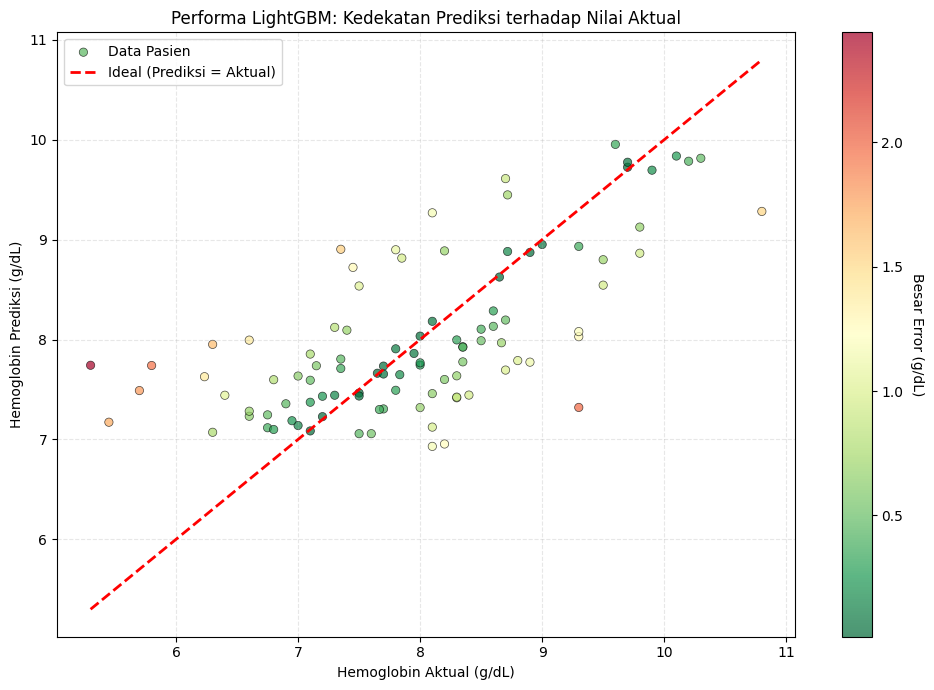

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = models_final["LightGBM"].predict(X_test)
error_abs = np.abs(y_test - y_pred)

plt.figure(figsize=(10, 7))

# hijau untuk error kecil, merah untuk error besar)
scatter = plt.scatter(y_test, y_pred, 
                      c=error_abs, 
                      cmap='RdYlGn_r', 
                      alpha=0.7, 
                      edgecolors='k', 
                      linewidths=0.5,
                      label='Data Pasien')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Ideal (Prediksi = Aktual)')

cbar = plt.colorbar(scatter)
cbar.set_label('Besar Error (g/dL)', rotation=270, labelpad=15)

plt.xlabel("Hemoglobin Aktual (g/dL)")
plt.ylabel("Hemoglobin Prediksi (g/dL)")
plt.title("Performa LightGBM: Kedekatan Prediksi terhadap Nilai Aktual")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

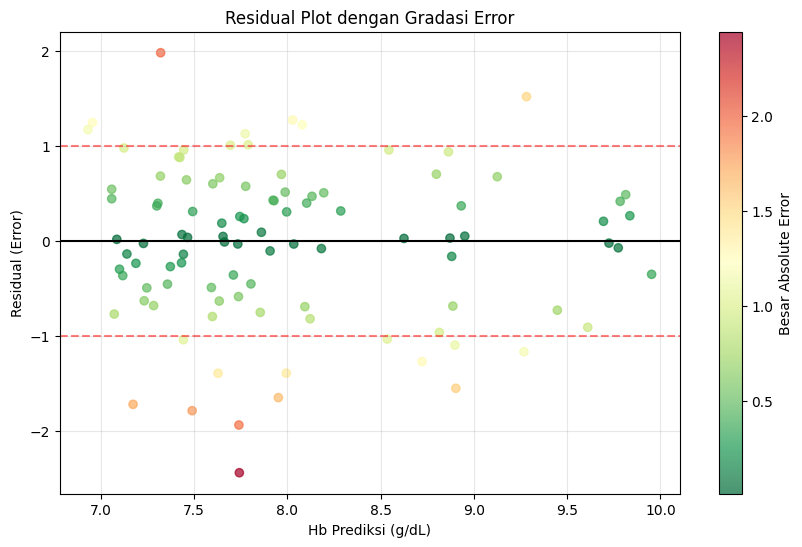

In [ ]:
import numpy as np

# Hitung residual dan absolut error
residuals = y_test - y_pred
abs_error = np.abs(residuals)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(y_pred, residuals, c=abs_error, cmap='RdYlGn_r', alpha=0.7)

plt.axhline(y=0, color='black', linestyle='-', linewidth=1.5) # Garis pusat
plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)  # Batas error 1.0
plt.axhline(y=-1, color='red', linestyle='--', alpha=0.5) # Batas error -1.0

plt.colorbar(scatter, label='Besar Absolute Error')
plt.xlabel("Hb Prediksi (g/dL)")
plt.ylabel("Residual (Error)")
plt.title("Residual Plot dengan Gradasi Error")
plt.grid(True, alpha=0.3)
plt.show()

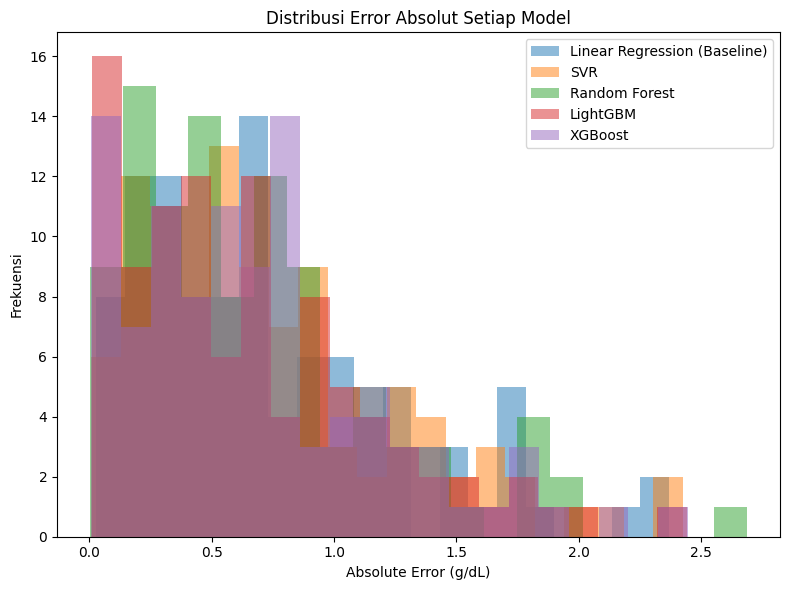

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for name, model in models_final.items():
    y_pred = model.predict(X_test)
    abs_error = np.abs(y_test - y_pred)
    
    plt.hist(abs_error, bins=20, alpha=0.5, label=name)

plt.xlabel("Absolute Error (g/dL)")
plt.ylabel("Frekuensi")
plt.title("Distribusi Error Absolut Setiap Model")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Windows\AppData\Local\Temp\ipykernel_7064\3502629487.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors, labels=models_final.keys(), showfliers=False)


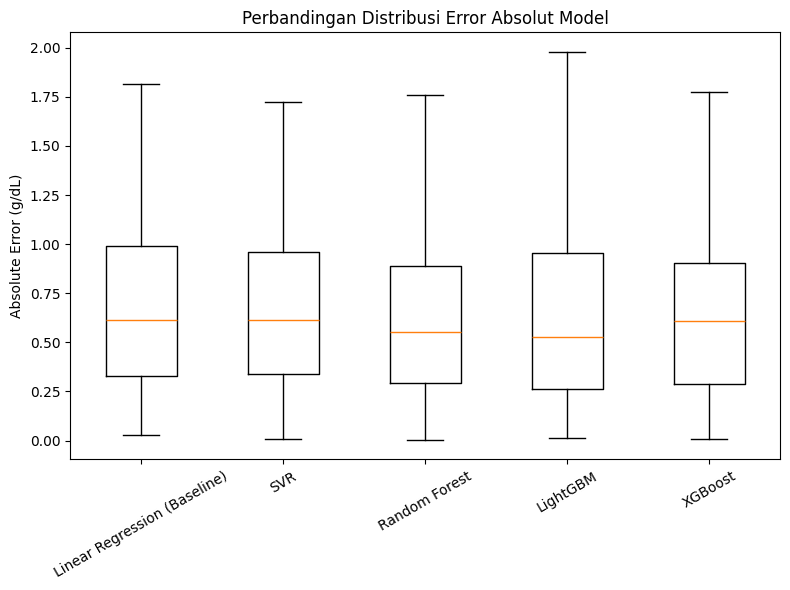

In [131]:
errors = []

for name, model in models_final.items():
    y_pred = model.predict(X_test)
    abs_error = np.abs(y_test - y_pred)
    errors.append(abs_error)

plt.figure(figsize=(8,6))
plt.boxplot(errors, labels=models_final.keys(), showfliers=False)
plt.ylabel("Absolute Error (g/dL)")
plt.title("Perbandingan Distribusi Error Absolut Model")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [ ]:
y_pred_svr = models_final["LightGBM"].predict(X_test)

plot_df = pd.DataFrame({
'Actual': y_test.values,
'Predicted': y_pred_svr,
'EPO_Status': X_test['epo'].map({1: 'Mendapat EPO', 0: 'Tidak Mendapat EPO'}).values
})

mae_epo = mean_absolute_error(
plot_df[plot_df['EPO_Status'] == 'Mendapat EPO']['Actual'],
plot_df[plot_df['EPO_Status'] == 'Mendapat EPO']['Predicted']
)
mae_no_epo = mean_absolute_error(
plot_df[plot_df['EPO_Status'] == 'Tidak Mendapat EPO']['Actual'],
plot_df[plot_df['EPO_Status'] == 'Tidak Mendapat EPO']['Predicted']
)

plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

sns.scatterplot(
data=plot_df,
x='Actual',
y='Predicted',
hue='EPO_Status',
style='EPO_Status',
palette={'Tidak Mendapat EPO': '#e74c3c', 'Mendapat EPO': '#3498db'},
s=120,
alpha=0.7,
edgecolor='w'
)

max_val = max(plot_df['Actual'].max(), plot_df['Predicted'].max())
min_val = min(plot_df['Actual'].min(), plot_df['Predicted'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='black', lw=2, linestyle='--', label='Garis Ideal (y=x)')

info_text = f'MAE (EPO): {mae_epo:.4f}\nMAE (Non-EPO): {mae_no_epo:.4f}'
plt.text(min_val + 0.2, max_val - 0.8, info_text,
fontsize=12, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

plt.title('Grafik Actual vs Predicted\nBerdasarkan Status Pemberian EPO', fontsize=15, pad=15)
plt.xlabel('Kadar Hb Aktual (g/dL)', fontsize=12)
plt.ylabel('Kadar Hb Prediksi (g/dL)', fontsize=12)
plt.legend(title='Status Pasien', loc='lower right')

plt.tight_layout()
plt.show()


In [ ]:
# =========================================================
# ABLATION STUDY UNTUK 5 ALGORITMA SEKALIGUS
# =========================================================

fitur_lag = ['hb_lag', 'hb_lag2'] 
scenarios = {
    "Lag Only": fitur_lag,
    "Clinical Only": [col for col in X.columns if col not in fitur_lag],
    "Full Model": X.columns.tolist()
}

ablation_summary = []

for scenario_name, feature_list in scenarios.items():
    print(f"Menjalankan Eksperimen: {scenario_name}...")
    
    X_train_sub = X_train[feature_list]
    X_test_sub = X_test[feature_list]
    
    current_models = {
        "Linear Regression": LinearRegression(),
        "SVR": Pipeline([
            ('scaler', StandardScaler()),
            ('model', SVR(**study_svr.best_params))
        ]),
        "Random Forest": RandomForestRegressor(**study_rf.best_params, random_state=42),
        "LightGBM": LGBMRegressor(**study_lgbm.best_params, random_state=42, verbose=-1),
        "XGBoost": XGBRegressor(**xgb_params)
    }
    
    for model_name, model in current_models.items():
        # Training
        model.fit(X_train_sub, y_train)
        
        # Prediksi
        y_pred = model.predict(X_test_sub)
        
        # Hitung MAE
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        ablation_summary.append({
            "Skenario": scenario_name,
            "Algoritma": model_name,
            "MAE": mae,
            "R2": r2
        })

df_ablation_full = pd.DataFrame(ablation_summary)
pivot_mae = df_ablation_full.pivot(index='Algoritma', columns='Skenario', values='MAE')

print("\n--- HASIL ABLATION STUDY (MAE) ---")
print(pivot_mae)

Menjalankan Eksperimen: Lag Only...
Menjalankan Eksperimen: Clinical Only...
Menjalankan Eksperimen: Full Model...

--- HASIL ABLATION STUDY (MAE) ---
Skenario           Clinical Only  Full Model  Lag Only
Algoritma                                             
LightGBM                0.737483    0.645685  0.718389
Linear Regression       0.789403    0.729648  0.725714
Random Forest           0.773546    0.680771  0.697111
SVR                     0.813201    0.739923  0.731201
XGBoost                 0.777749    0.675835  0.707114


In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

fitur_lag = ['hb_lag', 'hb_lag2', 'hb_delta']
all_features = X_train.columns.tolist()
fitur_klinis = [col for col in all_features if col not in fitur_lag]

def get_predictions_lgbm(features):
    model = LGBMRegressor(**study_lgbm.best_params)

    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', model)
    ])
    
    pipe.fit(X_train[features], y_train)
    return pipe.predict(X_test[features])

pred_lag = get_predictions_lgbm(fitur_lag)
pred_klinis = get_predictions_lgbm(fitur_klinis)
pred_full = get_predictions_lgbm(all_features)

# DataFrame Evaluasi untuk Data Test
df_eval = X_test.copy()
df_eval['y_actual'] = y_test.values
df_eval['pred_lag_only'] = pred_lag
df_eval['pred_full_model'] = pred_full

# Kasus "Anomali" (Hb berubah drastis > 1.0 g/dL dibandingkan bulan lalu)
df_eval['perubahan_asli'] = df_eval['y_actual'] - df_eval['hb_lag']
df_anomali = df_eval[abs(df_eval['perubahan_asli']) > 1.0].copy()

df_anomali['err_lag'] = abs(df_anomali['y_actual'] - df_anomali['pred_lag_only'])
df_anomali['err_full'] = abs(df_anomali['y_actual'] - df_anomali['pred_full_model'])

print(f"Ditemukan {len(df_anomali)} data pasien dengan perubahan Hb drastis (>1.0 g/dL)")
print("=" * 50)
print(df_anomali[['y_actual', 'hb_lag', 'perubahan_asli', 'pred_full_model', 'err_full', 'err_lag']].head(10))

# Perbandingan MAE khusus di data Kritis
mae_lag_anomali = df_anomali['err_lag'].mean()
mae_full_anomali = df_anomali['err_full'].mean()

print("\n--- ANALISIS DATA KRITIS (PASIEN TIDAK STABIL) ---")
print(f"MAE Jika hanya pakai Hb Lag : {mae_lag_anomali:.4f}")
print(f"MAE Dengan Fitur Klinis Lengkap : {mae_full_anomali:.4f}")

improvement = ((mae_lag_anomali - mae_full_anomali) / mae_lag_anomali) * 100
print(f"Peningkatan Akurasi pada Kasus Sulit: {improvement:.2f}%")

KeyboardInterrupt: 